In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
X_train = pd.read_csv('X_train.csv')
X_train = X_train.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [4]:
X_valid = pd.read_csv('X_valid.csv')
X_valid = X_valid.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [5]:
X_train.head()

,item_type,utc_date,country_code,item_price,currency,numTracks,dateModified,datePublished,albumRelease,Genre,inAlbum,tags
0,a,1.599956e+09,au,2.184,AUD,6.0,1.305590e+09,1.305518e+09,1,rock,is,other
1,t,1.600334e+09,nz,1.300,GBP,1.0,1.574759e+09,1.574760e+09,1,electronic,in,house
2,a,1.600598e+09,de,0.000,USD,3.0,1.376506e+09,1.359491e+09,1,electronic,is,80s
3,a,1.601296e+09,nz,0.000,USD,25.0,1.606288e+09,1.567251e+09,1,experimental,is,disco
4,a,1.601310e+09,fr,0.000,USD,6.0,1.586739e+09,1.413672e+09,1,metal,is,other


In [6]:
import datetime

In [7]:
utc_datetime = [datetime.datetime.utcfromtimestamp(x) for x in X_train['utc_date']]
utc_datetime_valid = [datetime.datetime.utcfromtimestamp(x) for x in X_valid['utc_date']]

In [8]:
day_month_year = [y.strftime('%a/%d') for y in utc_datetime]
day_month_year_valid = [y.strftime('%a/%d') for y in utc_datetime_valid]

In [9]:
fridays = ['Fri/01', 'Fri/02', 'Fri/03', 'Fri/04', 'Fri/05', 'Fri/06', 'Fri/07']

In [10]:
BC_fridays = [1 if day in fridays else 0 for day in day_month_year]
BC_fridays_valid = [1 if day in fridays else 0 for day in day_month_year_valid]

In [11]:
X_train['BC_fridays'] = BC_fridays
X_valid['BC_fridays'] = BC_fridays_valid

In [12]:
X_train = X_train.drop(['utc_date', 'dateModified', 'datePublished'], axis = 1)
X_valid = X_valid.drop(['utc_date', 'dateModified', 'datePublished'], axis = 1)

In [13]:
cols = num_cols = ['item_price', 'numTracks', 'albumRelease']

for c in cols:
    X_train[c] = (X_train[c] - np.mean(X_train[c]))/ np.std(X_train[c])
    X_valid[c] = (X_valid[c] - np.mean(X_valid[c]))/ np.std(X_valid[c])

In [14]:
X_comb = pd.concat([X_train, X_valid])
X_comb_d = pd.get_dummies(X_comb)

In [15]:
X_train_d2 = X_comb_d[0:362907]
X_valid_d2 = X_comb_d[362907:]

In [16]:
X_train_d2.columns

Index(['item_price', 'numTracks', 'albumRelease', 'BC_fridays', 'item_type_a',
       'item_type_t', 'country_code_ad', 'country_code_ae', 'country_code_af',
       'country_code_ag',
       ...
       'tags_folk', 'tags_hiphop', 'tags_hiphop/rap', 'tags_house',
       'tags_indie', 'tags_london', 'tags_newyork', 'tags_other',
       'tags_spokenword', 'tags_techno'],
      dtype='object', length=258)

In [17]:
y_train = pd.read_csv('y_train.csv')

In [18]:
y_train = y_train['amount_paid_usd']

In [19]:
y_train = (y_train - np.mean(y_train))/np.std(y_train)

In [20]:
y_valid = pd.read_csv('y_valid.csv')
y_valid = y_valid['amount_paid_usd']
y_valid = (y_valid - np.mean(y_valid))/np.std(y_valid)

In [21]:
X_comb = pd.concat([X_train, X_valid])
X_comb_d = pd.get_dummies(X_comb)

In [22]:
X_train_d2 = X_comb_d[0:362907]
X_valid_d2 = X_comb_d[362907:]

In [23]:
X_train_d2.shape, X_valid_d2.shape

((362907, 258), (120969, 258))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
#defining the model
def nn_model(neurons):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_d2.shape[1], activation = 'relu'))
    neurons = neurons / 2
    model.add(Dense(neurons, activation = 'relu'))
    neurons = neurons / 2
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dense(units=1, activation = 'linear'))
    model.compile(loss='mse', optimizer= 'adam')
    return model

In [26]:
neurons = [64, 128, 256]

In [27]:
def train_nn(neurons, batch):
    es = EarlyStopping(monitor = 'val_loss', mode='min', patience = 8, restore_best_weights = True)
    for n in neurons:
        nn_mod = nn_model(n)
        print(nn_mod.summary())
        nn_mod.fit(X_train_d2, y_train, batch_size = batch, epochs = 50, validation_data=(X_valid_d2, y_valid), callbacks=[es])
        pred = nn_mod.predict(X_valid_d2)
        print(sqrt(mean_squared_error(y_valid, pred)))

In [28]:
mod1 = train_nn(neurons, batch=25)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16576     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19,201
Trainable params: 19,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
14517/14517 [==============================] - 19s 1ms/step - loss: 0.2994 - val_loss: 0.2983
Epoch 2/50
14517/14517 [==============================] - 12s 842us/step -

14517/14517 [==============================] - 17s 1ms/step - loss: 0.2728 - val_loss: 0.2872
Epoch 11/50
14517/14517 [==============================] - 17s 1ms/step - loss: 0.2716 - val_loss: 0.2877
Epoch 12/50
14517/14517 [==============================] - 17s 1ms/step - loss: 0.2706 - val_loss: 0.2870
Epoch 13/50
14517/14517 [==============================] - 17s 1ms/step - loss: 0.2693 - val_loss: 0.2877
Epoch 14/50
14517/14517 [==============================] - 17s 1ms/step - loss: 0.2685 - val_loss: 0.2896
Epoch 15/50
14517/14517 [==============================] - 18s 1ms/step - loss: 0.2674 - val_loss: 0.2887
Epoch 16/50
14517/14517 [==============================] - 18s 1ms/step - loss: 0.2664 - val_loss: 0.2873
Epoch 17/50
14517/14517 [==============================] - 18s 1ms/step - loss: 0.2655 - val_loss: 0.2906
Epoch 18/50
14517/14517 [==============================] - 17s 1ms/step - loss: 0.2650 - val_loss: 0.2868
Epoch 19/50
14517/14517 [==============================] -

In [29]:
mod2 = train_nn(neurons, batch=50)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                16576     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 19,201
Trainable params: 19,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
7259/7259 [==============================] - 14s 2ms/step - loss: 0.3001 - val_loss: 0.2967
Epoch 2/50
7259/7259 [==============================] - 7s 960us/step - lo

7259/7259 [==============================] - 9s 1ms/step - loss: 0.2776 - val_loss: 0.2876
Epoch 7/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2756 - val_loss: 0.2865
Epoch 8/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2741 - val_loss: 0.2864
Epoch 9/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2722 - val_loss: 0.2870
Epoch 10/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2706 - val_loss: 0.2870
Epoch 11/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2691 - val_loss: 0.2892
Epoch 12/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2674 - val_loss: 0.2908
Epoch 13/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2663 - val_loss: 0.2881
Epoch 14/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2648 - val_loss: 0.2881
Epoch 15/50
7259/7259 [==============================] - 9s 1ms/step - loss: 0.2639 - va

In [30]:
mod3 = train_nn(neurons, batch=100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                16576     
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 19,201
Trainable params: 19,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
3630/3630 [==============================] - 11s 3ms/step - loss: 0.3010 - val_loss: 0.2952
Epoch 2/50
3630/3630 [==============================] - 4s 1ms/step - loss

3630/3630 [==============================] - 7s 2ms/step - loss: 0.2666 - val_loss: 0.2880
Epoch 12/50
3630/3630 [==============================] - 7s 2ms/step - loss: 0.2651 - val_loss: 0.2897
Epoch 13/50
3630/3630 [==============================] - 7s 2ms/step - loss: 0.2637 - val_loss: 0.2882
Epoch 14/50
3781/3781 [==============================] - 2s 621us/step
0.5350576476599244


In [31]:
mod4 = train_nn(neurons, batch=150)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                16576     
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 dense_39 (Dense)            (None, 1)                 17        
                                                                 
Total params: 19,201
Trainable params: 19,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
2420/2420 [==============================] - 10s 4ms/step - loss: 0.3096 - val_loss: 0.2981
Epoch 2/50
2420/2420 [==============================] - 2s 1ms/step - loss

2420/2420 [==============================] - 4s 2ms/step - loss: 0.2698 - val_loss: 0.2899
Epoch 10/50
2420/2420 [==============================] - 4s 2ms/step - loss: 0.2677 - val_loss: 0.2879
Epoch 11/50
2420/2420 [==============================] - 4s 2ms/step - loss: 0.2660 - val_loss: 0.2875
Epoch 12/50
2420/2420 [==============================] - 4s 2ms/step - loss: 0.2644 - val_loss: 0.2875
Epoch 13/50
2420/2420 [==============================] - 4s 2ms/step - loss: 0.2628 - val_loss: 0.2908
Epoch 14/50
2420/2420 [==============================] - 4s 2ms/step - loss: 0.2614 - val_loss: 0.2908
Epoch 15/50
3781/3781 [==============================] - 2s 584us/step
0.5352310207768269


In [32]:
mod5 = train_nn(neurons, batch=200)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                16576     
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 19,201
Trainable params: 19,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
1815/1815 [==============================] - 9s 5ms/step - loss: 0.3080 - val_loss: 0.2960
Epoch 2/50
1815/1815 [==============================] - 2s 1ms/step - loss

1815/1815 [==============================] - 6s 3ms/step - loss: 0.2711 - val_loss: 0.2876
Epoch 9/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2695 - val_loss: 0.2914
Epoch 10/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2676 - val_loss: 0.2881
Epoch 11/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2656 - val_loss: 0.2872
Epoch 12/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2642 - val_loss: 0.2882
Epoch 13/50
1815/1815 [==============================] - 6s 4ms/step - loss: 0.2628 - val_loss: 0.2889
Epoch 14/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2610 - val_loss: 0.2877
Epoch 15/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2599 - val_loss: 0.2868
Epoch 16/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2582 - val_loss: 0.2891
Epoch 17/50
1815/1815 [==============================] - 6s 3ms/step - loss: 0.2569 - 

In [34]:
#retrain network

#X_train = pd.concat([X_train_d2, X_valid_d2])
y_train_d = pd.concat([y_train, y_valid])

In [ ]:
X_train.shape

In [35]:
X_test = pd.read_csv('X_test.csv')
X_test = X_test.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [36]:
utc_datetime = [datetime.datetime.utcfromtimestamp(x) for x in X_test['utc_date']]
day_month_year = [y.strftime('%a/%d') for y in utc_datetime]
BC_fridays = [1 if day in fridays else 0 for day in day_month_year]
X_test['BC_fridays'] = BC_fridays
X_test = X_test.drop(['utc_date', 'dateModified', 'datePublished'], axis = 1)

for c in cols:
    X_test[c] = (X_test[c] - np.mean(X_test[c]))/ np.std(X_test[c])
    


In [37]:
X_test.shape, X_train.shape

((120970, 10), (362907, 10))

In [38]:
X_valid.shape

(120969, 10)

In [39]:
X_comb = pd.concat([X_train, X_valid, X_test])
X_comb_d = pd.get_dummies(X_comb)

#X_test_d2 = X_comb_d[483876:]

In [40]:
X_train_d2 = X_comb_d[0:483876]
X_test_d2 = X_comb_d[483876:]

In [41]:
X_test_d2.shape

(120970, 261)

In [42]:
X_train_d2.shape, X_test_d2.shape

((483876, 261), (120970, 261))

In [43]:
X_test_d2.columns

Index(['item_price', 'numTracks', 'albumRelease', 'BC_fridays', 'item_type_a',
       'item_type_t', 'country_code_ad', 'country_code_ae', 'country_code_af',
       'country_code_ag',
       ...
       'tags_folk', 'tags_hiphop', 'tags_hiphop/rap', 'tags_house',
       'tags_indie', 'tags_london', 'tags_newyork', 'tags_other',
       'tags_spokenword', 'tags_techno'],
      dtype='object', length=261)

In [46]:
y_train_d.shape, y_test.shape

((483876,), (120970,))

In [47]:
def nn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_d2.shape[1], activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(units=1, activation = 'linear'))
    model.compile(loss='mse', optimizer= 'adam')
    return model

In [45]:
y_test = pd.read_csv('y_test.csv')
y_test = y_test['amount_paid_usd']
y_test = (y_test - np.mean(y_test))/np.std(y_test)

In [48]:
es = EarlyStopping(monitor = 'val_loss', mode='min', patience = 7, restore_best_weights = True)
nn_mod = nn_model()
print(nn_mod.summary())
nn_mod.fit(X_train_d2, y_train_d, batch_size = 150, epochs = 100, validation_data=(X_test_d2, y_test), callbacks=[es])
pred = nn_mod.predict(X_test_d2)
print(sqrt(mean_squared_error(y_test, pred)))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 128)               33536     
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dense_63 (Dense)            (None, 1)                 33        
                                                                 
Total params: 43,905
Trainable params: 43,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
3226/3226 [==============================] - 12s 3ms/step - loss: 0.2989 - val_loss: 0.2891
Epoch 2/100
3226/3226 [==============================] - 5s 1ms/step - l

In [49]:
error_df = pd.DataFrame()

In [50]:
y_test.shape

(120970,)

In [51]:
pred.shape

(120970, 1)

In [52]:
error_df['true'] = y_test
error_df['pred'] = pred

In [53]:
error_df.head()

,true,pred
0,1.236321,1.403226
1,-0.932073,-0.708241
2,-0.708427,-0.676174
3,1.085603,0.878245
4,-0.929642,-0.878404


In [54]:
error_df['error'] = error_df['true'] - error_df['pred']

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'prediction error')

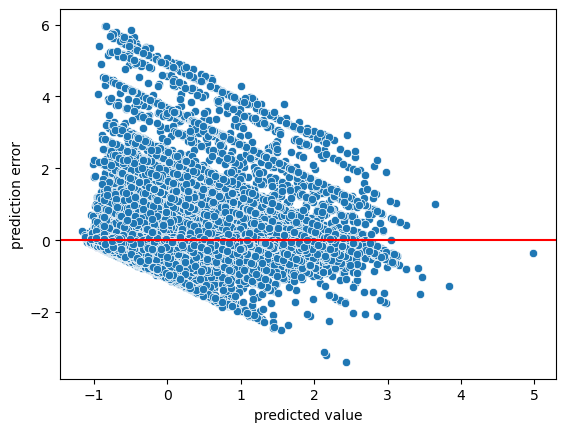

In [56]:
sns.scatterplot(data = error_df, x = 'pred', y = 'error')
plt.axhline(y = 0, color = 'r')
plt.xlabel('predicted value')
plt.ylabel('prediction error')